## In this notebook: Figs 5A, S4, S5

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import mne

import glob
import os
import sys
from scipy.io import savemat, loadmat
from scipy.stats import pearsonr, spearmanr, sem
from statsmodels.stats.multitest import fdrcorrection
import scipy.stats as stats

# from pingouin import rm_anova

# from statannotations.Annotator import Annotator

plt.style.use("article.mplstyle")

sys.path.append('.././utils')
from ERP_utils import *
from plot_utils import *
from update_sub_lists import*
mne.set_log_level('CRITICAL')

In [6]:

# erp_times = create_erp_times(-0.5, 0.5, 128)
xtick_fontsize = 15
axis_fontsize = 20
xmin = -0.2
xmax = 0.5

listen_erp_dir = '../analysis_listen/listen_ERP_data_n05to05_30Hz/'
motor_erp_dir = '../analysis_motor/motor_ERP_data_n05to05_30Hz/'
error_erp_dir = '../analysis_error/error_ERP_data_n05to05_30Hz_corrected/'


In [7]:
def extract_erp_data(erp_dir):
    erp_data = mne.read_evokeds(erp_dir)[0].get_data()
    return erp_data

In [8]:
#load ERPs 
# subjects_to_process = ['01','04', '05', '06', '07', '08', '09', '10', '11', '12']
subjects_to_process = ['01','04', '05', '06', '07', '08', '09', '10', '11', '12', 
                       '13', '14', '15', '16', '18', '17', '19', '20']
periods = ['post']
listen_ev = []
motor_ev = []
error_ev = []

maps = 'all'

for subject in subjects_to_process:
    for period in periods:


        error_erp_path= os.path.join(error_erp_dir, f'error_ERP_{maps}_{period}_{subject}.fif')
        listen_erp_path= os.path.join(listen_erp_dir, f'listen_ERP_{period}_{subject}.fif')
        motor_erp_path = os.path.join(motor_erp_dir, f'motor_ERP_{period}_{subject}.fif')


        try:
            listen_erp_sub = mne.read_evokeds(listen_erp_path)[0].filter(0.1, 15)
            motor_erp_sub = mne.read_evokeds(motor_erp_path)[0].filter(0.1, 15)
            error_erp_sub = mne.read_evokeds(error_erp_path)[0].filter(0.1, 15)
        except FileNotFoundError as e:
            print(f"File not found for sub {subject}, period {period}: {e}")
            continue
        except Exception as e:
            print(f"Other problem for sub {subject}, period {period}: {e}")
            continue


        listen_ev.append(listen_erp_sub)
        motor_ev.append(motor_erp_sub)
        error_ev.append(error_erp_sub)


#combine evokeds
listen_gave = mne.combine_evoked(listen_ev, weights = 'equal')
motor_gave = mne.combine_evoked(motor_ev, weights = 'equal')
error_gave = mne.combine_evoked(error_ev, weights = 'equal')


File not found for sub 17, period post: File does not exist: "/Users/cindyzhang/Documents/Audiomotor_Piano/AM-repo/ARTICLE_FIGS/../analysis_motor/motor_ERP_data_n05to05_30Hz/motor_ERP_post_17.fif"


## Figure S4: grand average ERP

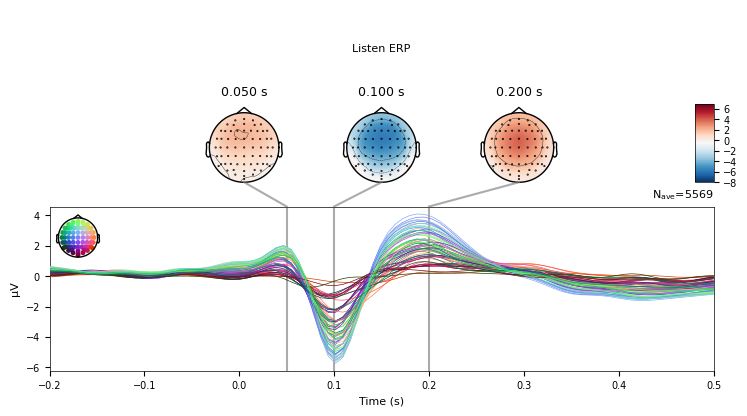

In [9]:
fig = mne.viz.plot_evoked_joint(
    listen_gave,
    picks='eeg',
    exclude=[],
    times = [0.05, 0.1, 0.2],
    ts_args=dict(xlim=(xmin, xmax)),
    topomap_args=dict(vlim = (-8,7)),
    title = 'Listen ERP',
)

# fig.savefig('listen_erp.svg')

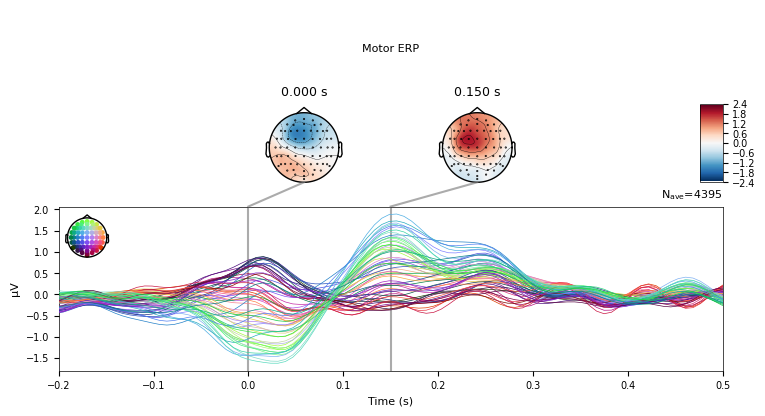

In [10]:
fig = mne.viz.plot_evoked_joint(
    motor_gave,
    picks='eeg',
    exclude=[],
    times = [0, 0.15],
    ts_args=dict(xlim=(xmin, xmax)),
    topomap_args=dict(vlim = (-2.3,2.3)),
    title = 'Motor ERP',
)

# fig.savefig('motor_erp.svg')

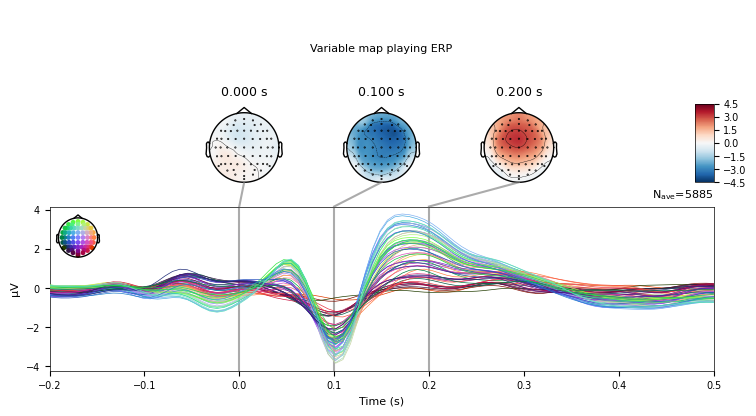

In [11]:
fig = mne.viz.plot_evoked_joint(
    error_gave,
    picks='eeg',
    exclude=[],
    times = [0, 0.1, 0.2],
    ts_args=dict(xlim=(xmin, xmax)),
    topomap_args=dict(vlim = (-4.5,4.5)),
    title = 'Variable map playing ERP',
)

# fig.savefig('error_erp.svg')

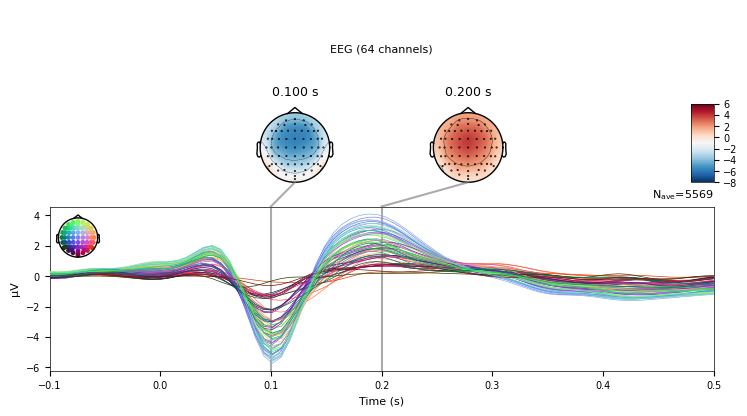

In [12]:
fig = mne.viz.plot_evoked_joint(
    listen_gave,
    picks='eeg',
    exclude=[],
    times=[0.1, 0.2],
    ts_args=dict(xlim=(-0.1, 0.5)),
    topomap_args=dict(vlim=(-8, 6))
)

## Figure 5A: average ERP in Fz for each task

In [13]:
#load ERPs 
subjects_to_process = ['01','04', '05', '06', '07', '08', '09', '10', '11', '12']
# subjects_to_process = ['15', '16',  '18']
periods = ['pre', 'post']
lme_df = []
maps = 'inv'
for subject in subjects_to_process:
    for period in periods:
        # error_erp_path= os.path.join(error_erp_dir, f'error_ERP_all_{period}_{subject}.fif')
        error_erp_path= os.path.join(error_erp_dir, f'error_ERP_{maps}_{period}_{subject}.fif')
        listen_erp_path= os.path.join(listen_erp_dir, f'listen_ERP_{period}_{subject}.fif')
        motor_erp_path = os.path.join(motor_erp_dir, f'motor_ERP_{period}_{subject}.fif')

        try:
            error_erp_sub = extract_erp_data(error_erp_path)
            listen_erp_sub = extract_erp_data(listen_erp_path)
            motor_erp_sub = extract_erp_data(motor_erp_path)
        except FileNotFoundError as e:
            print(f'file not found in sub {subject} {period}', e)
            continue
        
    

        lme_sub = {
            'subject': subject,
            'period': period,
            'listen_erp': listen_erp_sub,
            'motor_erp': motor_erp_sub,
            'error_erp': error_erp_sub
        }
        lme_df.append(lme_sub)
    
lme_df = pd.DataFrame(lme_df)

In [14]:
erp_times = create_erp_times(-0.5, 0.5, 128)

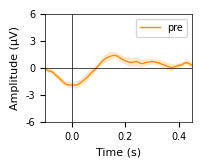

In [15]:
task = 'motor'
ch_to_plot = ['Fz']
ch_idx = ch_index(ch_to_plot)
plt.figure(figsize =( 1.9, 1.4))


mean_pre, sem_pre = find_mean_sem_evs(lme_df.query('period == "pre"'), ch_idx = ch_idx, col_to_ave=f'{task}_erp')
plot_mean_sem(erp_times, mean_pre, sem_pre, label = 'pre', color = 'darkorange')
# plot_mean_sem(erp_times, mean_post, sem_post, label = 'post', color = 'purple')

# Add labels, legend, and grid
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
# plt.title(f'ERP first and others, {period} training {ch_to_plot}')
plt.hlines(0, -0.5, 0.5, color = 'black')
plt.vlines(0, -6.5e-6, 6e-6, color = 'black')

plt.ticklabel_format(style='plain', axis='y')  # Disable scientific notation
# plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x * 1e6:.1f}'))  # Convert to µV
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{int(x * 1e6)}'))  # Convert to µV as integer

plt.xlim(-0.1, 0.45)
plt.ylim(-6e-6, 6e-6)
plt.yticks([-6e-6, -3e-6, 0, 3e-6, 6e-6], labels=['-6', '-3', '0', '3', '6'])
# plt.xticks(fontsize = xtick_fontsize)
# plt.yticks(fontsize = xtick_fontsize)
plt.legend(loc = 'upper right')

plt.savefig(f'./figures/{task}_erp.svg')

## Figure S5: ERP pre and post for each task

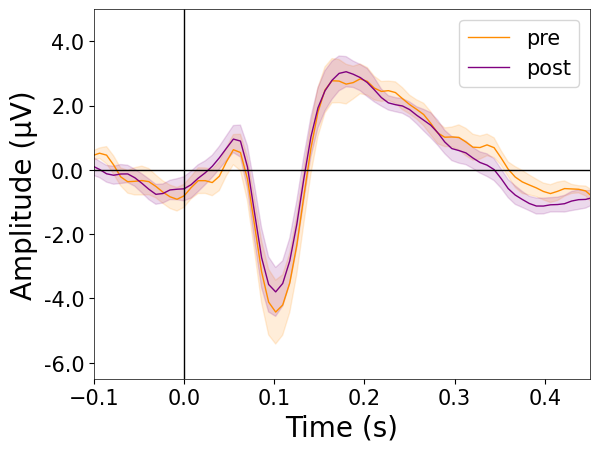

In [ ]:
task = 'error'
ch_to_plot = ['Fz']
ch_idx = ch_index(ch_to_plot)


mean_pre, sem_pre = find_mean_sem_evs(lme_df.query('period == "pre"'), ch_idx = ch_idx, col_to_ave=f'{task}_erp')
mean_post, sem_post = find_mean_sem_evs(lme_df.query('period == "post"'), ch_idx = ch_idx, col_to_ave=f'{task}_erp')
plot_mean_sem(erp_times, mean_pre, sem_pre, label = 'pre', color = 'darkorange')
plot_mean_sem(erp_times, mean_post, sem_post, label = 'post', color = 'purple')


config_erp_plot()
# plt.title(f'{task}', fontsize = 20)

plt.savefig(f'./figures/{task}_erp_prepost.svg')